# *contents*

- preparation: load and merge dataframes
- naive strategy: uses all in-sample data to fit one Total Least Squares (or PCA) model
- sliding window TLS

In [1]:
%matplotlib inline
import logging
import collections
import numpy as np
import scipy as sp
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import helper
import pprint
import log_setup

helper.chinese_font_setup()
log_setup.setup()

In [2]:
datainfo_code, datainfo_abbr = helper.datafiles_info_v2()
#datainfo_code

In [3]:
def build_big_df():
    series = []
    keys   = []
    for di in datainfo_code.values():
        df = pd.read_excel(di.path, header=0, index_col=0)
        #logging.info('{} {} {}'.format(di.code, di.name, df.shape))
        series.append(df.close)
        keys.append(di.code)
    df = pd.concat(series, axis=1, keys=keys)
    logging.info('result df shape: {}'.format(df.shape))
    return df

huge_df = build_big_df()
huge_df.describe()

[2023-05-03 01:48:27,494] [INFO]	[875842427.py:10:build_big_df] result df shape: (5410, 18)


,510050.SH,510300.SH,510500.SH,159915.SZ,159949.SZ,588000.SH,518880.SH,159781.SZ,159601.SZ,300750.SZ,300760.SZ,300059.SZ,300124.SZ,600519.SH,000858.SZ,000568.SZ,600809.SH,002304.SZ
count,4420.000000,2655.000000,2459.000000,2763.000000,1643.000000,594.000000,2372.000000,440.000000,357.000000,1185.000000,1101.000000,3120.000000,3035.000000,5182.000000,5275.000000,5298.000000,5357.000000,3262.000000
mean,2.017500,3.362446,5.382457,1.852079,0.898278,1.269764,3.053285,0.712639,0.865006,155.229266,281.180995,6.883751,22.692494,427.207998,51.576161,46.900142,46.776145,85.581907
std,0.762775,0.931155,1.199667,0.704466,0.303249,0.198064,0.584696,0.120683,0.070014,103.841653,101.208698,6.916949,21.835922,612.508235,70.949160,66.579176,85.714338,48.884643
min,0.517918,1.813988,2.819713,0.598000,0.425000,0.909000,2.167000,0.534000,0.721000,19.871648,68.250304,0.224905,2.681423,3.914016,2.443769,1.370304,1.510593,20.158486
25%,1.446302,2.777259,4.621834,1.356000,0.658000,1.078000,2.616000,0.616000,0.811000,44.810017,180.379435,0.902151,8.074883,58.181431,7.375643,5.582244,3.670246,49.367024
50%,1.983732,3.428157,5.610480,1.761000,0.814000,1.267500,2.774000,0.663500,0.851000,138.171262,306.500000,5.052485,14.481520,127.285914,22.568334,22.435865,13.068389,70.378281
75%,2.656780,3.953988,6.175000,2.354500,1.114000,1.432500,3.653000,0.843000,0.907000,241.142719,341.225268,8.873279,21.596514,568.686743,51.764661,44.201286,26.877031,111.620037
max,3.905555,5.629466,10.218341,3.790000,1.585000,1.670000,4.378000,0.994000,1.036000,379.149090,490.225738,26.761412,87.180843,2549.222392,335.942243,305.769613,372.042113,255.225037


<Axes: title={'center': '收盘价 (扩缩股、分红调整后)'}, ylabel='Adjusted Close'>

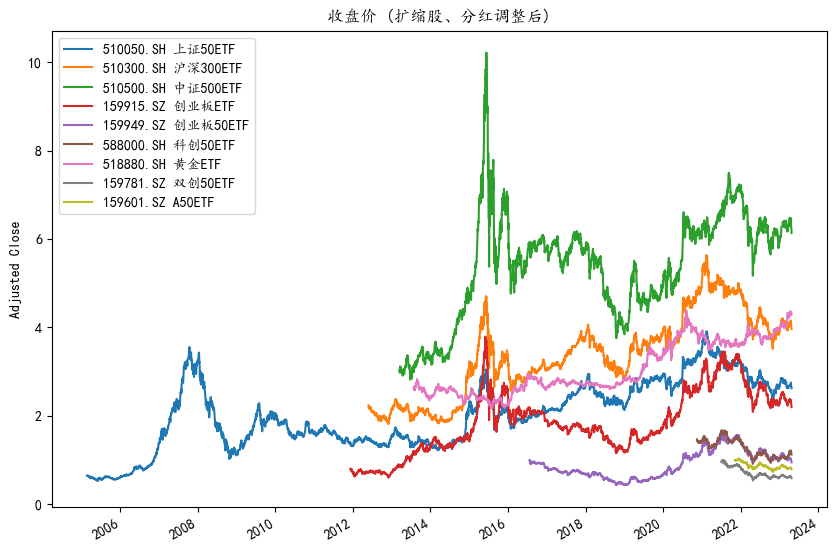

In [4]:
etf_df = huge_df[huge_df.columns[:9]].copy()
etf_df.rename(columns=dict(
    [ (di.code, '{} {}'.format(di.code, di.name)) for di in datainfo_code.values() ]), inplace=True)
etf_df.plot(figsize=(10,7), ylabel='Adjusted Close', title='收盘价 (扩缩股、分红调整后)')

In [5]:
def slice_pair(huge_df, abbr1, abbr2):
    info1 = datainfo_abbr[abbr1.upper()]
    info2 = datainfo_abbr[abbr2.upper()]
    slice_df = huge_df[[info1.code, info2.code]].copy()
    slice_df.dropna(axis=0, inplace=True)
    slice_df.rename(
        columns=dict(
            [(info1.code, info1.abbr), (info2.code, info2.abbr)]
        ), inplace=True)
    return slice_df

def plot_pair_price(pair):
    x = pair.iloc[:, 0]
    y = pair.iloc[:, 1]
    x_info = datainfo_abbr[pair.columns[0]]
    y_info = datainfo_abbr[pair.columns[1]]

    model  = sm.OLS(y, sm.add_constant(x))
    result = model.fit()
    print(result.summary())

    first_ymd = pair.index[0].strftime('%Y-%m-%d')
    last_ymd  = pair.index[-1].strftime('%Y-%m-%d')

    span = x.max() - x.min()
    x2 = np.linspace(x.min(), x.max(),
                     np.maximum(pair.shape[0] // 10, 500))
    y2 = result.params[0] + x2 * result.params[1]

    plt.figure(figsize=(8, 5), dpi=120)
    plt.scatter(x, y, marker='.', color='tab:blue')
    regress_title = 'OLS: $y = {:.2f} {:+.2f} \cdot x$'.format(*result.params)
    plt.plot(x2, y2, label=regress_title, color='tab:orange')
    plt.xlabel('{} {}'.format(x_info.code, x_info.name))
    plt.ylabel('{} {}'.format(y_info.code, y_info.name))
    plt.title('close price [{}, {}]'.format(first_ymd, last_ymd))
    plt.legend(loc='best')

# *Naive Strategy (only one TLS/PCA fit)*

In [6]:
def calculate_spread_info(dataframe, first_date='', last_date=''):
    if first_date and last_date:
        df = dataframe[first_date:last_date]
    elif first_date and not last_date:
        df = dataframe[first_date:]
    elif not first_date and last_date:
        df = dataframe[:last_date]
    else:
        df = dataframe

    x_name, y_name = df.columns
    result_df = (df - df.shift()).dropna(axis=0)
    #result_df = df.copy()

    pca = PCA()
    pca.fit(result_df)
    slope = pca.components_[1,0] / pca.components_[0,0]
    result_df['spread'] = result_df[y_name] - slope * result_df[x_name]
    result_df.rename(
        columns=dict([ (n, '{}_diff'.format(n)) for n in df.columns]),
        inplace=True)
    result_df = pd.concat([df, result_df], axis=1)
    logging.info('in shape {}, out shape {}'.format(df.shape, result_df.shape))

    RetCls = collections.namedtuple('SpreadInfo', 'dataframe beta'.split())
    return RetCls(dataframe=result_df, beta=slope)

def plot_strategy(strategy):
    names = strategy.dataframe.columns[:2]
    info1, info2 = datainfo_abbr[names[0]], datainfo_abbr[names[1]]
    color1, color2 = 'tab:blue', 'tab:orange'

    plt.figure(figsize=(10,12), dpi=120)
    first_ymd = strategy.dataframe.index[0].strftime('%Y-%m-%d')
    last_ymd  = strategy.dataframe.index[-1].strftime('%Y-%m-%d')
    plt.suptitle('时间段 [{}, {}], {} 交易日'.format(first_ymd, last_ymd, strategy.dataframe.shape[0]))

    plt.subplot(3, 1, 1)
    for info, color, ax in [(info1, color1, plt.gca()), (info2, color2, plt.gca().twinx())]:
        ax.plot(strategy.dataframe[info.abbr], color=color)
        ax.set_ylabel(info.name)
        ax.tick_params(axis='y', colors=color)
        ax.yaxis.label.set_color(color)
    plt.title('price')

    plt.subplot(3, 1, 2)
    for info, color, ax, legend_loc in [(info1, color1, plt.gca(), 'upper left'), (info2, color2, plt.gca().twinx(), 'upper right')]:
        data = strategy.dataframe['{}_diff'.format(info.abbr)]
        label = '$\mu={:.2f}, \sigma={:.2f}$'.format(data.mean(), data.std())
        if 0:
            ax.scatter(strategy.dataframe.index, data, color=color, marker='.', label=label)
        else:
            ax.plot(data, color=color, marker='.', label=label)
        ax.hlines(y=[data.mean()], xmin=strategy.dataframe.index[0], xmax=strategy.dataframe.index[-1], color='red')
        ax.set_ylabel(info.name)
        ax.tick_params(axis='y', colors=color)
        ax.yaxis.label.set_color(color)
        ax.legend(loc=legend_loc)
    plt.title('price diff')

    plt.subplot(3, 1, 3)
    spread = strategy.dataframe.spread
    plt.plot(strategy.dataframe.index, spread, marker='.')
    spread_std = spread.std()

    for k, color in [(1, 'orange'), (2, 'magenta')]:
        n_long  = np.sum(spread < -k * spread_std) # long the spread
        n_short = np.sum(spread > k * spread_std)  # short the spread
        label = '$\pm {{{}}}\sigma\;\;N_{{long}}={}\;N_{{short}}={}$'.format(k, n_long, n_short)
        plt.hlines(y=[- k * spread_std, k * spread_std], xmin=spread.index[0], xmax=spread.index[-1],
                   color=color, label=label)
    plt.legend(loc='best')
    plt.title('spread $\mu={:.2f}, \sigma={:.2f}$'.format(spread.mean(), spread.std()))


[2023-05-03 01:48:28,671] [INFO]	[612212371.py:23:calculate_spread_info] in shape (487, 2), out shape (487, 5)


                            OLS Regression Results                            
Dep. Variable:                   GZMT   R-squared:                       0.937
Model:                            OLS   Adj. R-squared:                  0.937
Method:                 Least Squares   F-statistic:                 7.606e+04
Date:                Wed, 03 May 2023   Prob (F-statistic):               0.00
Time:                        01:48:28   Log-Likelihood:                -32765.
No. Observations:                5074   AIC:                         6.553e+04
Df Residuals:                    5072   BIC:                         6.555e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8125      2.674      0.678      0.4

[2023-05-03 01:48:28,844] [INFO]	[612212371.py:23:calculate_spread_info] in shape (485, 2), out shape (485, 5)


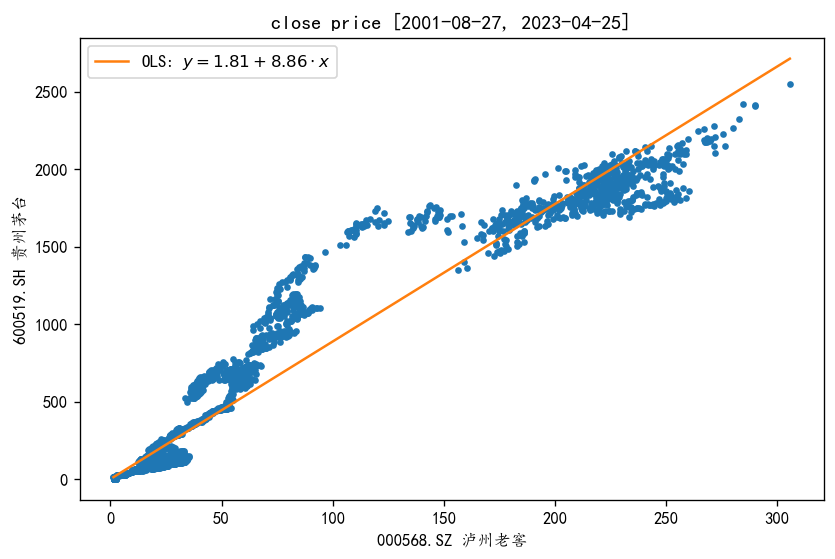

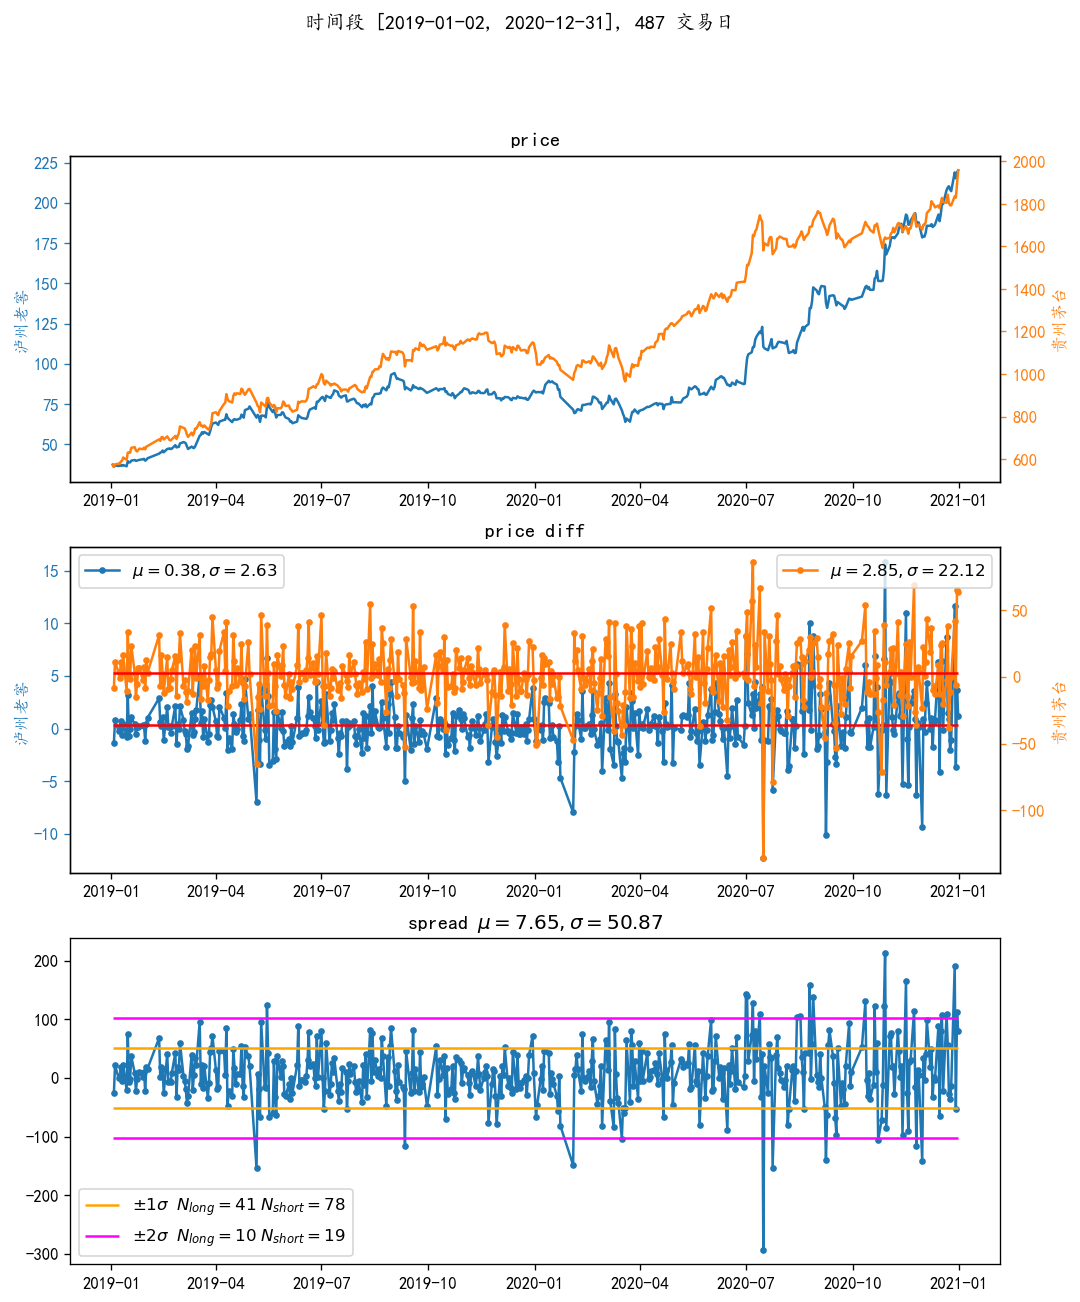

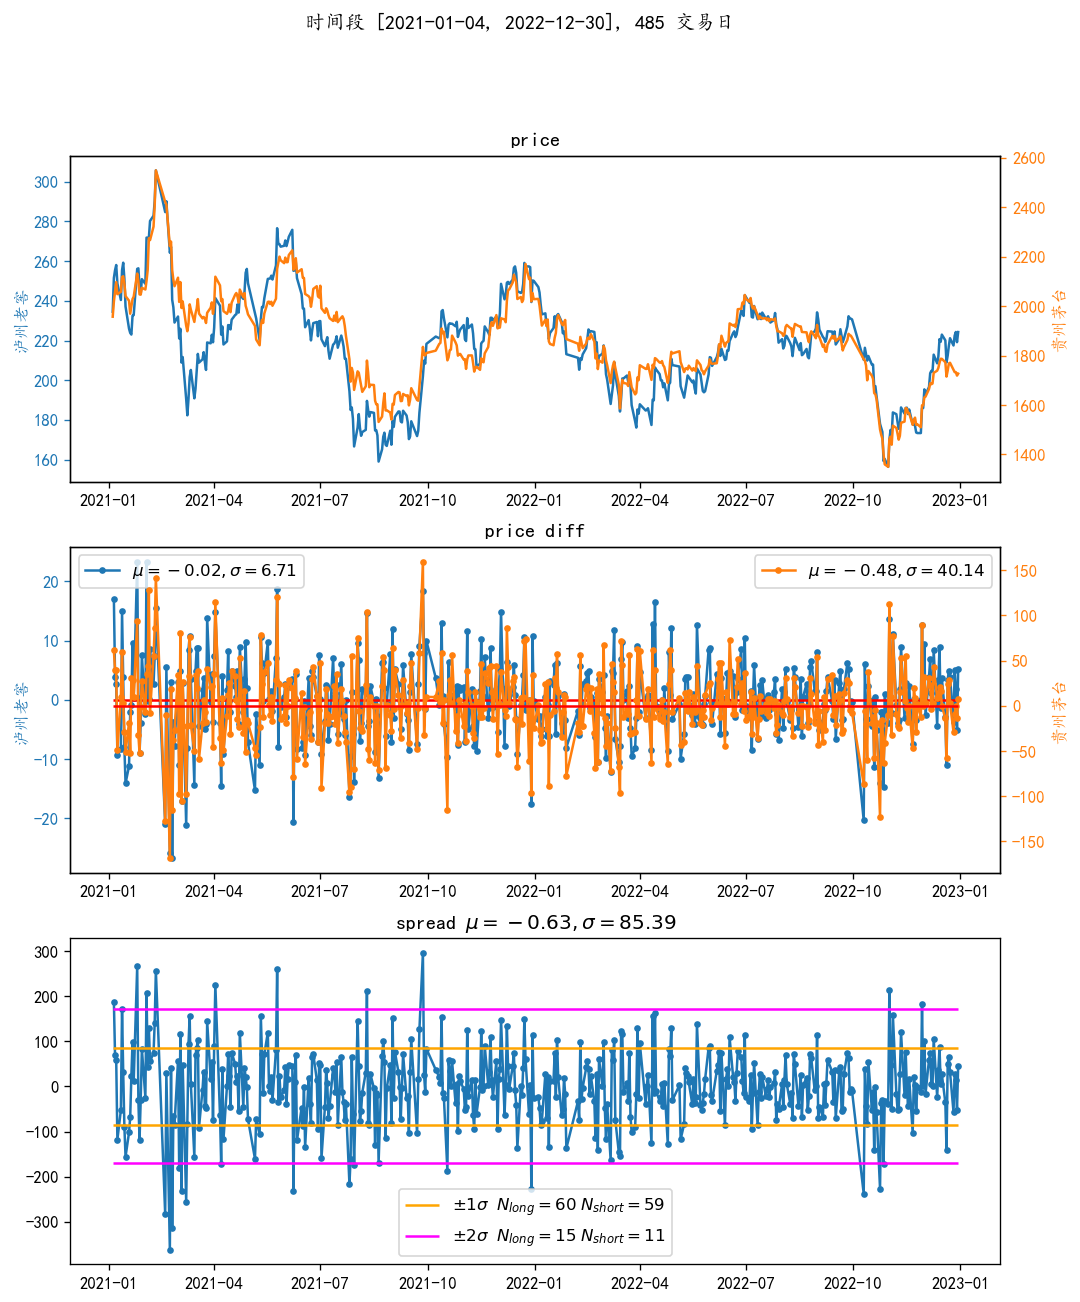

In [7]:
# pair_df = slice_pair(huge_df, 'wly', 'gzmt')
# pair_df = slice_pair(huge_df, 'cybetf', 'ndsd')
# pair_df = slice_pair(huge_df, 'cyb50etf', 'ndsd')
pair_df = slice_pair(huge_df, 'lzlj', 'gzmt')

plot_pair_price(pair_df)
# plot_strategy(calculate_spread_info(pair_df, '2017', '2018'))
plot_strategy(calculate_spread_info(pair_df, '2019', '2020'))
plot_strategy(calculate_spread_info(pair_df, '2021', '2022'))